In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import functional as F
import cv2
import xml.etree.ElementTree as ET
from PIL import Image

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

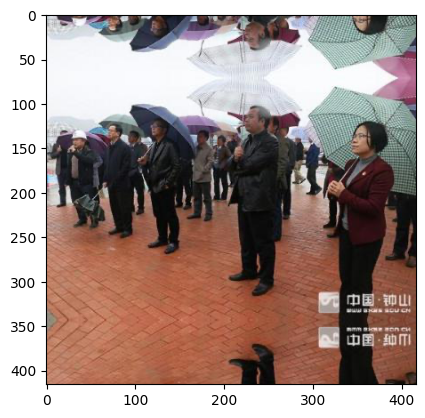

In [4]:
img = cv2.imread('/kaggle/input/hard-hat-detection/images/hard_hat_workers1006.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [5]:
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def visualize_single(image_path, xml_path):
    # Parse XML
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, name, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# # 🧪 Example usage
# visualize_single("images/image1.jpg", "annotations/image1.xml")


In [6]:
img_path = '/kaggle/input/hard-hat-detection/images/hard_hat_workers1005.png'
ann_path = '/kaggle/input/hard-hat-detection/annotations/hard_hat_workers1005.xml'

In [ ]:
visualize_single(img_path,ann_path)

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split

def split_data(image_dir,test_size=0.2,seed=42):
    image_files = sorted(os.listdir(image_dir))
    train_imgs, test_imgs = train_test_split(image_files, test_size=test_size, random_state=seed)
    return train_imgs, test_imgs

In [ ]:
#From this we get names of files - img and annotations have same names except for extension
train_files,valid_files = split_data('/kaggle/input/hard-hat-detection/images')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self,image_dir,annotation_dir,file_list,transforms=None,label_map=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.file_list = file_list
        self.label_map = label_map or {}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self,idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.image_dir,filename)
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)  # Convert PIL to np.array before Albumentations

        xml_file = filename.replace(".png", ".xml")
        xml_path = os.path.join(self.annotation_dir, xml_file)
        boxes, labels = self.parse_voc_xml(xml_path)
        # Albumentations expects boxes as list of [xmin, ymin, xmax, ymax]
        transformed = self.transforms(
            image=image,
            bboxes=boxes,
            category_ids=labels
        )
    
        image = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
        labels = torch.tensor(transformed['category_ids'], dtype=torch.int64)
    
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }
    
        return image, target
        # Uncomment this if you don't use Albumentations
        # boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # labels = torch.as_tensor(labels, dtype=torch.int64)

        # target = {
        #     "boxes": boxes,
        #     "labels": labels,
        #     "image_id": torch.tensor([idx])
        # }

        # if self.transforms:
        #     image = self.transforms(image)

        # return image, target

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.label_map.get(name, 0))
        return boxes, labels

In [11]:
label_map = {'head': 1, 'helmet': 2,'person':3}
img_dir = '/kaggle/input/hard-hat-detection/images'
ann_dir = '/kaggle/input/hard-hat-detection/annotations'

# transform = transforms.Compose([
#     # transforms.Resize((300, 300)),  # Resize all images to 300x300
#     transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
# ])
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

val_transform = A.Compose([
    A.Resize(300, 300),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))



/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [12]:
train_dataset = CustomDataset(img_dir,ann_dir,train_files,train_transform,label_map) #order matters
valid_dataset = CustomDataset(img_dir,ann_dir,valid_files,val_transform,label_map) #order matters

In [13]:
train_dataset[0]

(tensor([[[-0.1314,  0.1254,  0.1597,  ...,  1.7523,  1.6324,  1.8208],
          [-0.1657,  0.0227,  0.0569,  ...,  1.7009,  1.5810,  1.7865],
          [-0.0801, -0.1143, -0.1486,  ...,  1.6495,  1.5982,  1.7694],
          ...,
          [-0.6794,  0.4851, -0.0287,  ..., -0.2513, -0.2684,  0.1768],
          [-1.0390, -1.2617, -0.5767,  ...,  0.2111,  0.0227,  0.1426],
          [-0.1486, -0.3369,  0.2967,  ...,  0.3652,  0.0398,  0.3994]],
 
         [[-0.1975,  0.0651,  0.1001,  ...,  1.9384,  1.8158,  2.0259],
          [-0.2150, -0.0574, -0.0049,  ...,  1.8683,  1.7808,  1.9734],
          [-0.1450, -0.1800, -0.2150,  ...,  1.8333,  1.7808,  1.9384],
          ...,
          [-0.7227,  0.4678, -0.0399,  ...,  0.1001,  0.0826,  0.5378],
          [-1.0378, -1.2829, -0.5651,  ...,  0.6078,  0.4328,  0.5553],
          [-0.1450, -0.3375,  0.3102,  ...,  0.7654,  0.4678,  0.8179]],
 
         [[-0.0092,  0.2522,  0.2871,  ...,  2.0474,  1.9254,  2.1346],
          [-0.0441,  0.1476,

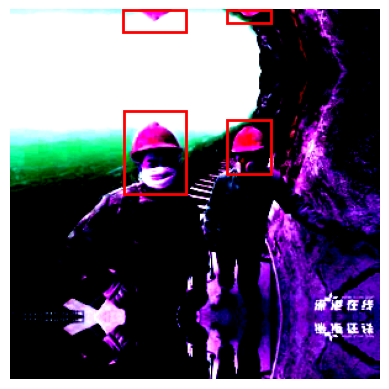

In [14]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import matplotlib.patches as patches

# Get one sample from dataset
img_tensor, target = train_dataset[1210]

# Convert tensor to PIL image for visualization (if needed)
# Or directly use matplotlib after permuting dimensions
img = img_tensor.permute(1, 2, 0).numpy()  # Convert [C, H, W] to [H, W, C]

# Plot image
fig, ax = plt.subplots(1)
ax.imshow(img)

# Plot bounding boxes
for box in target['boxes']:
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.show()


In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)


In [16]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 4  # head, helmet, background

model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 203MB/s] 


In [17]:
# ---- IoU Helper ----
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

In [18]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [23]:
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1} Train Loss: {epoch_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    test_loss = 0
    correct_boxes = 0
    total_pred_boxes = 0
    with torch.no_grad():
        for images, targets in valid_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # outputs = model(images)
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            test_loss += losses.item()

            for pred, target in zip(outputs, targets):
                pred_boxes = pred['boxes'].cpu().numpy()
                true_boxes = target['boxes'].cpu().numpy()

                matched = 0
                for p_box in pred_boxes:
                    for t_box in true_boxes:
                        if compute_iou(p_box, t_box) > 0.5:
                            matched += 1
                            break
                correct_boxes += matched
                total_pred_boxes += len(pred_boxes)

    accuracy = correct_boxes / total_pred_boxes if total_pred_boxes > 0 else 0
    print(f"Epoch {epoch+1} Valid Loss: {test_loss/len(valid_loader):.4f} | Accuracy (IoU>0.5): {accuracy:.4f}")

Epoch 1 Train Loss: 0.3586


AttributeError: 'list' object has no attribute 'values'

In [22]:
outputs

[{'boxes': tensor([[2.4344e+02, 1.0486e+02, 2.7362e+02, 1.3869e+02],
          [1.9878e+02, 1.0328e+02, 2.1816e+02, 1.2391e+02],
          [4.7214e+01, 1.0475e+02, 7.4238e+01, 1.3319e+02],
          [3.5453e+01, 8.0930e+01, 5.1934e+01, 1.0088e+02],
          [9.4752e+01, 8.5733e-02, 1.3490e+02, 1.3606e+01],
          [3.5619e+01, 7.9495e+01, 5.1645e+01, 1.0077e+02],
          [1.9909e+02, 1.0294e+02, 2.1813e+02, 1.2484e+02],
          [2.0414e+01, 7.8621e+01, 5.5555e+01, 1.4726e+02],
          [2.1794e+01, 1.1034e+02, 1.0154e+02, 2.6754e+02],
          [4.5229e+01, 1.0488e+02, 7.7382e+01, 1.3500e+02],
          [2.2316e+02, 1.0246e+02, 2.9415e+02, 2.8804e+02]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 2, 2, 2, 3, 3, 2, 3], device='cuda:0'),
  'scores': tensor([0.9884, 0.9838, 0.9753, 0.9374, 0.2017, 0.1831, 0.0687, 0.0548, 0.0546,
          0.0532, 0.0501], device='cuda:0')},
 {'boxes': tensor([[3.6983e+01, 1.4111e+02, 5.9974e+01, 1.6680e+02],
          [2.3197e+02, 1.6222e+02

In [ ]:
def plot_ground_truth_vs_prediction(model, dataset, device, num_images=5, score_threshold=0.5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    for idx in indices:
        img, target = dataset[idx]  # img is tensor, target is dict
        img = img.to(device)

        # Run prediction
        with torch.no_grad():
            prediction = model([img])[0]

        # Convert image back to CPU and numpy
        img_np = F.to_pil_image(img.cpu())
        img_np = np.array(img_np)

        # Plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img_np)

        # Plot ground truth boxes (green)
        for box in target["boxes"]:
            xmin, ymin, xmax, ymax = box
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, edgecolor='green', linewidth=2, label='GT'))

        # Plot predicted boxes (red) above threshold
        for i, box in enumerate(prediction["boxes"]):
            score = prediction["scores"][i].item()
            if score >= score_threshold:
                xmin, ymin, xmax, ymax = box
                ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                           fill=False, edgecolor='red', linewidth=2, label='Pred'))

        ax.set_title(f"Image {idx} - Green: GT | Red: Pred (score ≥ {score_threshold})")
        plt.axis("off")
        plt.show()


In [ ]:
plot_ground_truth_vs_prediction(model, valid_dataset, device, num_images=3)
